# Distributional and frequency effects in word embeddings: Shifted similarity distributions
## © 2018 Chris Culy, June 2018, rev. 2 July 2018
### [chrisculy.net](http://chrisculy.net/)

## Overview
This is one of a [series of posts](dist_freq_intro.html). In this post I look at the skew (in the ordinary, non-statistcal sense) of word vector similarities, showing that all four methods (Skip Gram with Negative Sampling (sgns), FastText (ft), Glove, and PPMI) show distorted distributions of similarities. However, the nature of the distortion differs dramatically across methods and across corpus sizes.

### Results and contributions

* **new** The distributions of word similarities have a positive mean
* **new** sgns and ft have similar distributions
* **new** glove and ppmi have somewhat similar distributions, very different from sgns and ft
* **new** random vectors are effectively not skewed 
* eliminating infrequent words 
    - **new** makes a big difference for sgns and ft, lowering the mean
    - **new** makes a small difference for glove and ppmi
 * **new** corpus size _may_ effect distributions, but not always
 * **new** very small corpora (like heartd) can be problematic for sgns and ft

[Download as Jupyter notebook](dist_freq_sim_shift.ipynb)

[Download supplemental Python code](dfewe.zip)

<input type="checkbox" id="toggleCheck" checked> Show Code

In [1]:
#imports
from dfewe import *

#for tables in Jupyter
from IPython.display import HTML, display
import tabulate

In [2]:
# some utilities
def show_title(t):
    display(HTML('<b>%s</b>' % t))

def show_table(data,headers,title):
    show_title(title)
    display(HTML(tabulate.tabulate(data,tablefmt='html', headers=headers)))

## Background

As I discussed briefly in the [introduction](dist_freq_intro.html), elementary discussions of word embeddings talk about using the cosine of the angle between two word vectors as the most common measure of their similarity (I'll return in a later post to other measures), and that the cosine ranges from -1 to 1. While that is mathematically correct, the _observed_ cosine similarities in a corpus do NOT seem to range from -1 to 1, but have a more restricted distribution. Furthermore, that distibution is shifted positively: i.e. vectors are somewhat more likely than average to be similar to each other. This shift is unexpected and I have not found any other mention of it.

In most of the examples in these posts, I'll be using two novels as my corpora: _Vanity Fair_ by William Makepeace Thackeray, and _The Heart of Darkness_ by Joseph Conrad. My motivation, laid out more fully in an [earlier post](http://chrisculy.net/lx/wordvectors/wvecs_testsets_parameters.nb.html) is that I am interested in how authors use language. In the terms of [[1]](#ref1), I take a corpus-centered approach. However, my perspective is slightly different from their characterization in that I am not interested in a book merely as a "sample" of the author's broader language, but rather I am in interested in the author's use of language _in that specfic context_. In a sense, this is the ultimate corpsus-centered approach. Of course, a comparison of contexts could also be interesting, such as across novels, or between fiction and non-fiction, or public versus private writing.

Getting back to the two novels used here, they are both _much_ smaller than typical corpora used for constructing word embeddings &mdash; vocabularies of thousands rather than hundreds of thousands or more. These small corpora sometimes pose challenges for word embedding methods, as we will see. 

In [3]:
#set up standard corpora + vectors
vfair_all = Setup.make_standard_sampler_and_vecs('vfair',5,100,1) #window=5, dims=100, min_count=1
heartd_all = Setup.make_standard_sampler_and_vecs('heartd',5,100,1) #window=5, dims=100, min_count=1

what = [['Vanity Fair (vfair)'],['Heart of Darkness (heartd)']]
for i,c in enumerate([vfair_all,heartd_all]):
    sampler = c['sampler']
    what[i].extend([sum(sampler.counts.values()), len(sampler.counts)])

show_table(what, headers=['Corpus','Tokens','Types'], title="Corpora sizes")

Although I focus on small corpora for the examples, **the general points and principles hold for word embeddings for large corora as well**, as I will show in a separate post (and as we already saw in the introduction with the GloVe vectors). In other words, the work here is relevant to _downstream applications_ of word embeddings as well.

## The distributions

Let's take a look at (samples from) the distributions of similarities in _Vanity Fair_ (aka _vfair_). Each of the four methods is shown in turn.

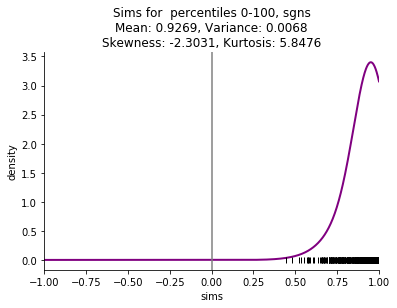

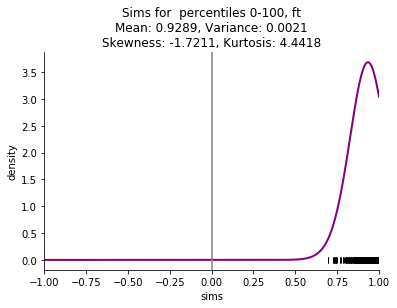

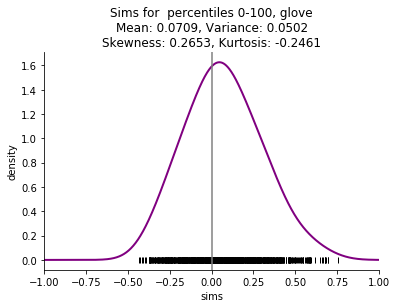

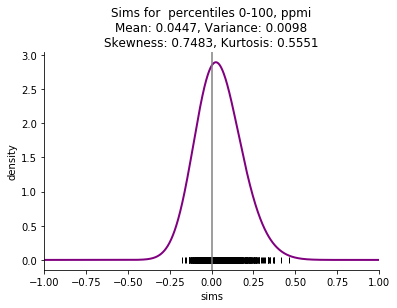

In [4]:
samples = 1000
show_title('Similarity density distributions for vfair, %d samples' % samples)
Plotting.compare_methods_range(vfair_all, samples=samples)

The first thing to notice, which was in fact the point of departure, is that all of the distributions have a positive mean, i.e. they are shifted positively. The second thing to notice is that sgns and ft show similar distributions, which are very different from the glove and ppmi distibutions, which in turn are somewhat similar to each other. This division between sgns and ft on the one hand glove and ppmi is one that will show up in almost every example we'll look at. It is _likely_ that these differences are due to the predicting vs. counting natures of the methods (sgns and ft are built by optimizing predictions about word co-occurrences, while glove and ppmi are build on the word co-occurrences themselves).

Now let's look at the distributions for _Heart of Darkness_ (aka _heartd_).

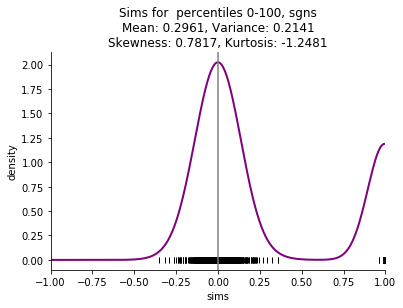

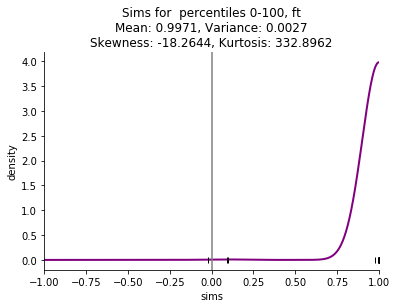

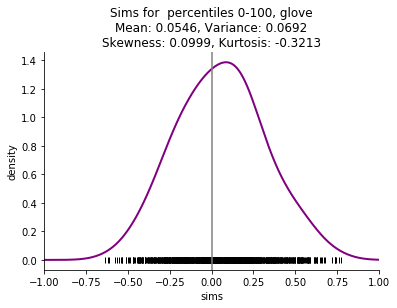

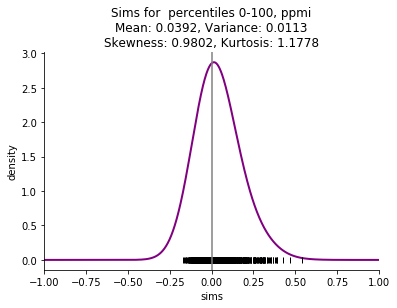

In [5]:
samples = 1000
show_title('Similarity density distributions for heartd, %d samples' % samples)
Plotting.compare_methods_range(heartd_all)

Here we see the first challenge of a very small corpus &mdash; the distribution for sgns is bimodal, unlike all the other methods and _all_ the methods for _vfair_, which are unimodal. On the other hand, the other methods show similar distributions across the two corpora sizes.

The prepocessing for these corpora has retained all words, unlike typical large scale word vectors which eliminate infrequent words. But we can eliminate infrequent words as well and then see what the distributions are for the resulting corpora.

In [6]:
window = 5
dims = 100
min_count = 10
vfair_min10 = Setup.make_standard_sampler_and_vecs('vfair',window,dims,min_count)
heartd_min10 = Setup.make_standard_sampler_and_vecs('heartd',window,dims,min_count)

When we look at vfair, we see that eliminating infrequent words makes a big difference for sgns and ft, but a small difference for glove and ppmi.

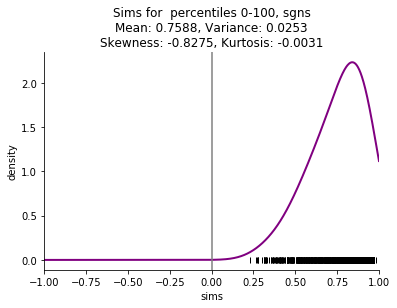

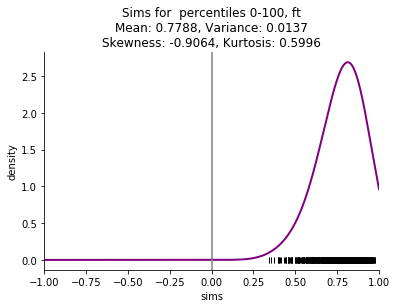

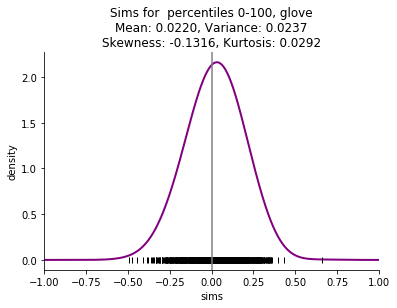

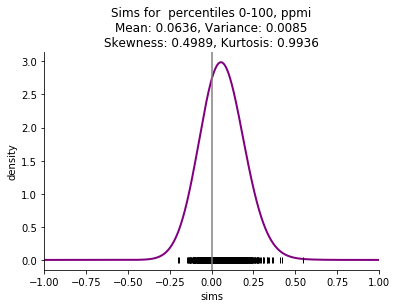

In [7]:
show_title('Similarity density distributions for vfair, min_count=%d, %d samples' % (min_count, samples))
Plotting.compare_methods_range(vfair_min10, samples=samples)

The results for heartd are even more striking &mdash; sgns and ft effectively collapse, while glove and ppmi are again similar in shape to their counterparts for vfair.

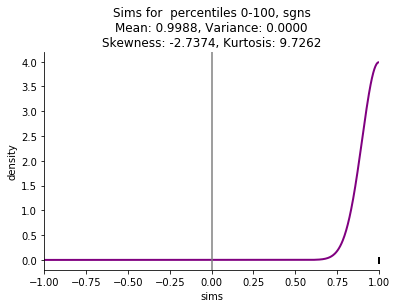

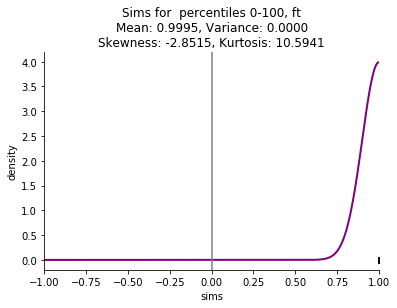

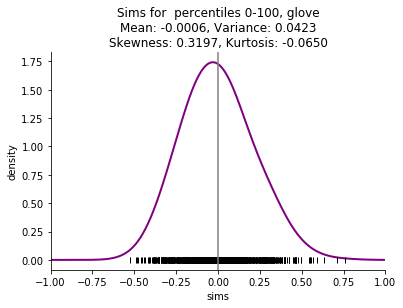

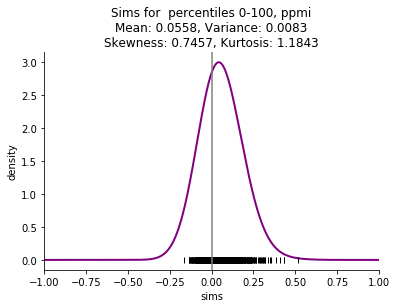

In [8]:
show_title('Similarity density distributions for heartd, min_count=%d, %d samples' % (min_count, samples))
Plotting.compare_methods_range(heartd_min10)

Lowering the minimum threshold to 5 for heartd restores sgns but not ft.

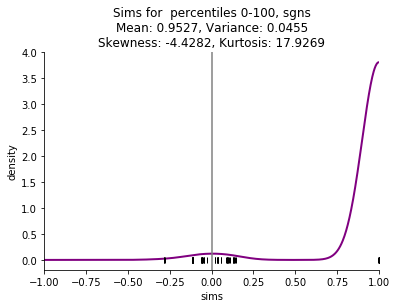

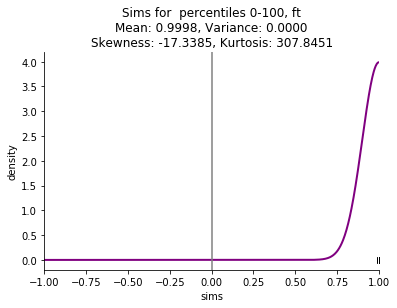

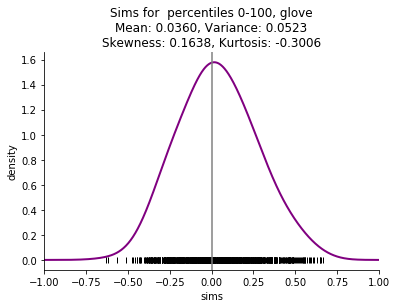

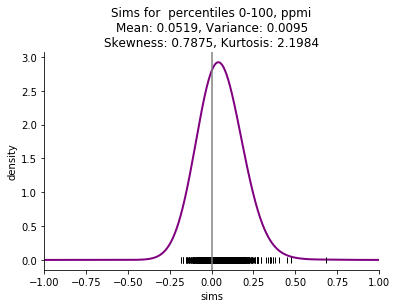

In [9]:
window = 5
dims = 100
min_count = 5
heartd_min5 = Setup.make_standard_sampler_and_vecs('heartd',window,dims,min_count)
show_title('Similarity density distributions for heartd, min_count=%d, %d samples' % (min_count, samples))
Plotting.compare_methods_range(heartd_min5)

While overall vocabulary size as well as omitting infrequent words affect the similarity distributions, the number of dimensions and the window size does not seem to have much effect on the distributions. Since the results are uninteresting, I'm leaving them out here (though they can be generated from the included code).

## Similarity distribution of random vectors

We might wonder how word vectors compare with random vectors. Here we create random vectors for the vocabulary of vfair, which each value in each vector is chosen uniformly from the range [-1,1]. We show the similarity distributions for 5 repetitions of this process.

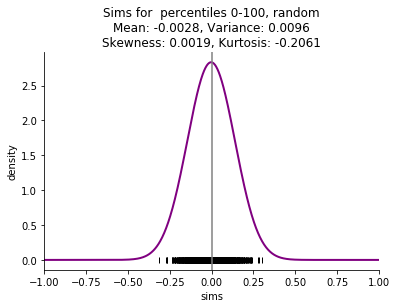

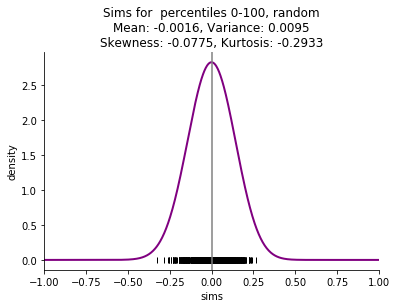

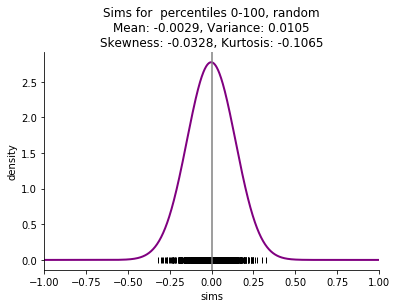

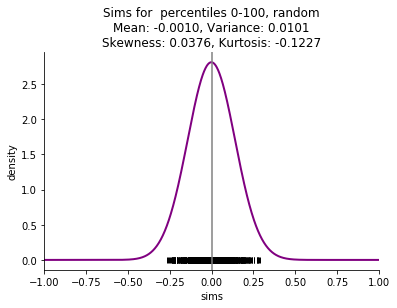

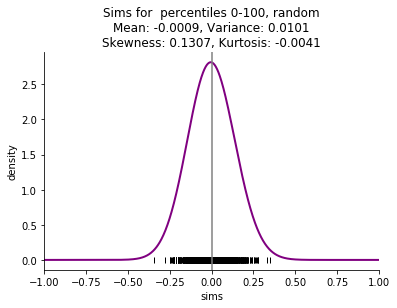

In [10]:
for _ in range(5):
    random_vecs = Setup.make_random_vecs(vfair_all['sampler'].counts,100,'vfair-random-100.vecs')

    random_combo = {
        'sampler' : vfair_all['sampler'],
        'random' : random_vecs
    }

    samples = 1000
    show_title('Similarity density distributions for random vfair, %d samples' % samples)
    Plotting.compare_methods_range(random_combo, methods=['random'], samples=samples)

The distributions are much more like glove and ppmi, but their means are about 10 times closer to 0, their variances are also close to 0, and the means can even be negative, which wasn't the case for glove and ppmi. Similarly, the skewness of the similarty distributions of the random vectors can be negative, though those of glove and ppmi were positive.

Seeing the similarity distributions of the random vectors gives us a better justification for saying that the word vector distributions are distorted. Random vectors have means very close to 0, either positive or negative, variances close to 0, and skewness also positive or negative. We've seen that sgns and ft are extremely shifted positively, which is one kind of distortion. Glove and ppmi also shifted positively and so distorted in that sense, but they also only have (at least in the examples here) postive skewness, unlike random vectors.

On the other hand, looking at the random vectors gives partial insight into why we don't see the full range of similarities in word vectors: getting exact similarity or dissimarity is extremely rare, so it is not surprising that we don't see it in the word vectors (or in the random vectors). However, we are still left with the other distortions unexplained. I'll return to some of these issues later.

I should note that there is a phenomenon whereby "[i]n a high-dimensional space, all pairwise distances between points seem identical" [[2]](#ref2), which also shows that the effect starts with dimension as low as 10. However, I don't think that is what is mainly going on here, since we see _different_ effects across methods with the same dimensions. The effect might play a small role, but it's not the explanation for the distortions.



## Summary

In this look at distributional and frequency effects in word embeddings we've seen that _similarity_ distributions are distorted, and that the prediction based methods (sgns and ft) are more distorted than the count based methods (glove and ppmi). Looking at random vectors gave a little insight into the lack of a full range of similarities.

Finally, we also saw that the prediction based methods (sgns and ft) do not work well for very small corpora.

[Back to the introduction](dist_freq_intro.html)


## The posts

* ➤ Shifted similarity distributions
* [Similarity stratification](dist_freq_stratification.html)
* [Frequency effects of vectors](dist_freq_vecs.html)
* [Strange geometry](dist_freq_geometry.html)
* [Distributional effects and hubs](dist_freq_hubs.html)
* [Recapitulation and next steps](dist_freq_recapit.html)

## References

<span id="ref1">[1]</span> Maria Antoniak and David Mimno. 2018. "Evaluating the Stability of Embedding-based Word Similarities" Transactions of the Association for Computational Linguistics, vol. 6, pp. 107–119.

<span id="ref2">[2]</span> Damien François, Vincent Wertz, and Michel Verleysen. 2007. IEEE Transaction on Knowledge and Data Engineering. 19:7, 873-876.

